#Geração de Dados Sintéticos com SDV (CTGAN)
Conjunto de dados: `Palmer Penguins` (Pinguins de Palmer) <br>

-Autoras: <br>
Ana Luíza Gomes Vieira (analuizagv2000@gmail.com) <br>
Sarah Vitória Moreira de Aquino (sarahvitoriaaquino@gmail.com)<br>

-Data: <br>
Junho de 2025

---

In [ ]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.9/185.9 kB 962.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.constraints import Constraint, Inequality, FixedCombinations, create_custom_constraint_class

In [ ]:
# Importar dataset
df = pd.read_csv('https://raw.githubusercontent.com/ftorresd/OCEAN-datasets/main/penguins/penguins.csv')

In [ ]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [ ]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [ ]:
print(df.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


In [ ]:
df = df.copy()

for coluna in df.columns:

    moda = df[coluna].mode()[0]

    df.fillna({coluna: moda}, inplace=True)

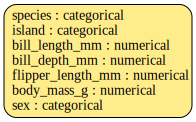

In [ ]:
metadados = SingleTableMetadata()
metadados.detect_from_dataframe(df)
metadados.visualize()

In [ ]:
metadados.save_to_json("metadata.json")

In [ ]:
from sdv.cag import Inequality

restricao_bico = Inequality(
    low_column_name='bill_depth_mm',
    high_column_name='bill_length_mm',
    strict_boundaries=True
)

In [ ]:
restricao_nadadeira = Inequality(
    low_column_name='bill_length_mm',
    high_column_name='flipper_length_mm',
    strict_boundaries=True
)

In [ ]:
restricao_massa = Inequality(
    low_column_name='flipper_length_mm',
    high_column_name='body_mass_g',
    strict_boundaries=True
)

In [ ]:
from sdv.cag import FixedCombinations
from sdv.single_table import CTGANSynthesizer

restricoes = [
    FixedCombinations(column_names=['species', 'island']),
    FixedCombinations(column_names=['species', 'sex']),
    restricao_bico,
    restricao_nadadeira,
    restricao_massa
]


sintetizador = CTGANSynthesizer(
    metadata=metadados,
    enforce_min_max_values=True,
    enforce_rounding=True,
    epochs=1500,
    verbose=True,
    log_frequency=False,
    discriminator_steps= 5,
    pac= 1,
    batch_size=1024,
    generator_dim=[128, 128, 128],
    discriminator_dim=[256, 128, 128]
)

sintetizador.add_constraints(restricoes)

/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:167: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


In [ ]:
violacoes = df[
    (df['bill_length_mm'] <= df['bill_depth_mm']) |
    (df['flipper_length_mm'] <= df['bill_length_mm']) |
    (df['body_mass_g'] <= df['flipper_length_mm'])
]
print(f"Linhas que violam as restrições de Inequality: {len(violacoes)}")

Linhas que violam as restrições de Inequality: 0


In [ ]:
if len(violacoes) > 0:
    display(violacoes.head())

In [ ]:
from sdv.single_table import CTGANSynthesizer

sintetizador.auto_assign_transformers(df)
sintetizador.get_transformers()

{'sex': UniformEncoder(),
 'species#island': UniformEncoder(),
 'bill_depth_mm.fillna': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'bill_depth_mm#bill_length_mm': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'bill_depth_mm#bill_length_mm.nan_component': UniformEncoder(),
 'flipper_length_mm.fillna': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'flipper_length_mm#body_mass_g': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'flipper_length_mm#body_mass_g.nan_component': UniformEncoder()}

In [ ]:
sintetizador.fit(df)

/usr/local/lib/python3.12/dist-packages/rdt/transformers/utils.py:188: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return data.infer_objects().fillna(np.nan).replace([np.nan], [None])
/usr/local/lib/python3.12/dist-packages/rdt/transformers/utils.py:188: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return data.infer_objects().fillna(np.nan).replace([np.nan], [None])
/usr/local/lib/python3.12/dist-packages/rdt/transformers/utils.py:188: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future v

In [ ]:
synthetic_data = sintetizador.sample(
    num_rows=10_000
)

In [ ]:
#salvando o dataset
synthetic_data.to_json("dados_sinteticos.json", orient="records")

In [ ]:
sintetizador.get_loss_values()

,Epoch,Generator Loss,Discriminator Loss
0,0,0.052765,-0.008864
1,1,0.041447,-0.013893
2,2,0.025458,-0.025259
3,3,0.008005,-0.037511
4,4,-0.040803,-0.039295
...,...,...,...
1495,1495,-0.204787,-0.163512
1496,1496,-0.178520,-0.185874
1497,1497,-0.172320,-0.179870
1498,1498,-0.167686,-0.195258


In [ ]:
fig = sintetizador.get_loss_values_plot()
fig.show()

In [ ]:
synthetic_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Chinstrap,Dream,41.9,15.6,202.0,3422.0,FEMALE
1,Adelie,Dream,36.2,15.6,186.0,3592.0,FEMALE
2,Adelie,Biscoe,44.7,20.0,203.0,4040.0,MALE
3,Gentoo,Biscoe,46.4,15.7,216.0,4408.0,FEMALE
4,Chinstrap,Dream,40.6,16.4,217.0,4076.0,MALE


#Avaliação Geral

In [ ]:
from sdv.evaluation.single_table import run_diagnostic

diagnostico = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadados
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 764.41it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 303.12it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [ ]:
diagnostico.get_details(property_name='Data Validity')

,Column,Metric,Score
0,species,CategoryAdherence,1.0
1,island,CategoryAdherence,1.0
2,bill_length_mm,BoundaryAdherence,1.0
3,bill_depth_mm,BoundaryAdherence,1.0
4,flipper_length_mm,BoundaryAdherence,1.0
5,body_mass_g,BoundaryAdherence,1.0
6,sex,CategoryAdherence,1.0


In [ ]:
diagnostico.get_details(property_name='Data Structure')

,Metric,Score
0,TableStructure,1.0


In [ ]:
from sdv.evaluation.single_table import evaluate_quality

relatorio_de_qualidade = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadados
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 200.28it/s]|
Column Shapes Score: 95.7%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 142.98it/s]|
Column Pair Trends Score: 89.1%

Overall Score (Average): 92.4%



In [ ]:
relatorio_de_qualidade.get_details('Column Shapes')

,Column,Metric,Score
0,species,TVComplement,0.961865
1,island,TVComplement,0.947972
2,bill_length_mm,KSComplement,0.933240
3,bill_depth_mm,KSComplement,0.964653
4,flipper_length_mm,KSComplement,0.947112
5,body_mass_g,KSComplement,0.960526
6,sex,TVComplement,0.983349


In [ ]:
relatorio_de_qualidade.get_details('Column Pair Trends')

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,species,island,ContingencySimilarity,0.946663,NaN,NaN
1,species,bill_length_mm,ContingencySimilarity,0.801967,NaN,NaN
2,species,bill_depth_mm,ContingencySimilarity,0.838186,NaN,NaN
3,species,flipper_length_mm,ContingencySimilarity,0.789272,NaN,NaN
4,species,body_mass_g,ContingencySimilarity,0.864453,NaN,NaN
5,species,sex,ContingencySimilarity,0.961016,NaN,NaN
6,island,bill_length_mm,ContingencySimilarity,0.869953,NaN,NaN
7,island,bill_depth_mm,ContingencySimilarity,0.841658,NaN,NaN
8,island,flipper_length_mm,ContingencySimilarity,0.797512,NaN,NaN
9,island,body_mass_g,ContingencySimilarity,0.868409,NaN,NaN


#Avaliação por variável

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data= df,
    synthetic_data= synthetic_data,
    column_name='island',
    metadata=metadados
)

fig.show()

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data= df,
    synthetic_data= synthetic_data,
    column_name='species',
    metadata=metadados
)

fig.show()

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data= df,
    synthetic_data=synthetic_data,
    metadata=metadados,
    column_name='sex'
)

fig.show()

In [ ]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

diagnostico = run_diagnostic(df, synthetic_data, metadados)

relatorio_de_qualidade = evaluate_quality(df, synthetic_data, metadados)

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadados,
    column_name='bill_length_mm'
)

fig.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 459.05it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 365.45it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 272.88it/s]|
Column Shapes Score: 95.7%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 153.80it/s]|
Column Pair Trends Score: 89.1%

Overall Score (Average): 92.4%



In [ ]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

diagnostico = run_diagnostic(df, synthetic_data, metadados)

relatorio_de_qualidade = evaluate_quality(df, synthetic_data, metadados)

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadados,
    column_name='bill_depth_mm'
)

fig.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 652.82it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 407.33it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 286.53it/s]|
Column Shapes Score: 95.7%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 161.73it/s]|
Column Pair Trends Score: 89.1%

Overall Score (Average): 92.4%



In [ ]:
diagnostico = run_diagnostic(df, synthetic_data, metadados)

relatorio_de_qualidade = evaluate_quality(df, synthetic_data, metadados)

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadados,
    column_name='flipper_length_mm'
)

fig.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 410.66it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 378.31it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 296.39it/s]|
Column Shapes Score: 95.7%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 164.82it/s]|
Column Pair Trends Score: 89.1%

Overall Score (Average): 92.4%



In [ ]:
diagnostico = run_diagnostic(df, synthetic_data, metadados)

relatorio_de_qualidade = evaluate_quality(df, synthetic_data, metadados)

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadados,
    column_name='body_mass_g'
)

fig.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 809.73it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 383.43it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 243.65it/s]|
Column Shapes Score: 95.7%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 154.77it/s]|
Column Pair Trends Score: 89.1%

Overall Score (Average): 92.4%



#Comparação da Distribuição Conjunta

In [ ]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_names=['species', 'island'],
    metadata=metadados
)

fig.show()

In [ ]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data= df,
    synthetic_data= synthetic_data,
    column_names=['species', 'sex'],
    metadata=metadados
)

fig.show()